In [5]:
import geopandas as gpd
import pandas as pd
import folium
import branca
import mapclassify as mc

# ── 1) Load your data 
# Load your Milan shapefile
gdf_shp = gpd.read_file("/Users/adriancantera/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Thesis/Thesis_Code/Data_Milano/REAL_NIL/NIL_WM.shp")
# Sort by NIL alphabetically
gdf_shp.sort_values(by="NIL", inplace=True)
# Load Excel with indicators
df_excel = pd.read_excel("Milan_indicator_index.xlsx", sheet_name="Reference_table_2_good", engine="openpyxl")
# Sort by NIL alphabetically
df_excel.sort_values(by="NIL", inplace=True)

# ── 2) Clean join keys to avoid mismatches
df_excel['NIL'] = df_excel['NIL'].astype(str).str.strip()
gdf_shp['NIL'] = gdf_shp['NIL'].astype(str).str.strip()

# ── 3) Merge 
gdf_merged_2 = gdf_shp.merge(
    df_excel[['NIL', 'FINAL_INDICATOR_INJUSTICE_18-30','ECO_iNDEX_18-30','EDU_iNDEX_18-30','HEA_iNDEX_18-30','SOC_iNDEX_18-30','LIV_iNDEX_18-30']].rename(
        columns={'FINAL_INDICATOR_INJUSTICE_18-30': 'indicator',
                 'ECO_iNDEX_18-30': 'eco_index',
                 'EDU_iNDEX_18-30': 'edu_index',
                 'HEA_iNDEX_18-30': 'hea_index',
                 'SOC_iNDEX_18-30': 'soc_index',
                 'LIV_iNDEX_18-30': 'liv_index'}
    ),
    on='NIL', how='left'
)

# ── 4) Ensure WGS84 (lat/lon) for web maps
if gdf_merged_2.crs is None:
    # set your source CRS if you know it, then convert
    # gdf_merged_2 = gdf_merged_2.set_crs("EPSG:32632")  # example for UTM32N
    pass
gdf_merged_2 = gdf_merged_2.to_crs(epsg=4326)

# Optional: simplify geometry to reduce file size (tune tolerance)
gdf_for_web = gdf_merged_2.copy()
gdf_for_web['geometry'] = gdf_for_web.geometry.simplify(0.00003, preserve_topology=True)


In [6]:
import folium, branca, mapclassify as mc
import geopandas as gpd
import pandas as pd
import numpy as np

# Base Map 
center = gdf_for_web.geometry.unary_union.centroid
m = folium.Map(location=[center.y, center.x], zoom_start=12, tiles=None)
folium.TileLayer('cartodbpositron', name='Base (fixed)', control=False).add_to(m)

#  Shape of the NILS
outline_style = {
    'fillColor': 'white',
    'fillOpacity': 0.0,
    'color': '#333333',
    'weight': 1,
}
folium.GeoJson(
    gdf_for_web.geometry,
    style_function=lambda x: outline_style,
    name='Milan Outline (Fixed)',
    control=False,
    interactive=False,
    tooltip=False
).add_to(m)


# Creation of a function to add layers and legends
def add_layer_and_legend(map_obj, gdf, field, layer_name, colors, n_classes=4, show=False):
    
    gdf_local = gdf.copy()
    gdf_local[field] = pd.to_numeric(gdf_local[field], errors='coerce')
    vals = gdf_local[field].dropna()
    vals = vals[np.isfinite(vals)]
    
    vmin = float(vals.min()) if vals.notna().any() else 0.0
    vmax = float(vals.max()) if vals.notna().any() else 1.0
    if vmin == vmax and vals.notna().any():
        vmin = vmin - 0.5
        vmax = vmax + 0.5
        if vmin < 0 and vals.min() >= 0: vmin = 0

    classifier = None # Force equal interval by default

    # Create the Colormap
    if vals.empty:
        cmap = branca.colormap.LinearColormap(colors=['#d3d3d3', '#d3d3d3'], vmin=0, vmax=1).to_step(n=2)
        cmap.caption = "Sin datos"
        cmap.index = [0, 1]
    
    elif classifier:
        bins = [vmin] + list(classifier.bins)
        cmap = branca.colormap.LinearColormap(colors=colors, vmin=vmin, vmax=vmax).to_step(index=bins)
        cmap.caption = f"{layer_name} (Quantiles)"
        cmap.index = [round(x, 2) for x in cmap.index] 

    else:
        
        cmap = branca.colormap.LinearColormap(colors=colors, vmin=vmin, vmax=vmax).to_step(n=n_classes)
        cmap.caption = f"{layer_name} (Equal Interval)"
        cmap.index = [round(x, 2) for x in cmap.index] # 
    
    # Define the style function
    def style_fn(feature):
        val = feature['properties'].get(field)
        if val is None or not np.isfinite(val):
            return {'fillColor': '#d3d3d3', 'color': 'black', 'weight': 0.8, 'fillOpacity': 0.7, 'fill': True}
        # Compara float vs float (¡correcto!)
        return {'fillColor': cmap(val), 'color': 'black', 'weight': 0.8, 'fillOpacity': 0.95, 'fill': True}

    tooltip = folium.GeoJsonTooltip(
        fields=['NIL', field], aliases=['NIL:', f'{layer_name}:'],
        localize=True, sticky=True, labels=True
    )

    # Adding the style_fn to the folium GeoJson layer
    layer = folium.GeoJson(
        data=gdf_local[['NIL', field, 'geometry']].to_json(),
        style_function=style_fn, 
        tooltip=tooltip,
        name=layer_name, show=show
    ).add_to(map_obj)

    # Create the HTML 
    legend_html = f"""
      <div style="font-weight:800; margin-bottom:12px;">{layer_name}</div>
      {cmap._repr_html_()}
    """

    return layer, legend_html

# Adding each of the layers and legends

# FINAL_INDEX_LAYER
final_colors = ['#ffffff','#c6b1c9','#72467c','#000000','#000000']
final_layer, final_legend_html = add_layer_and_legend(
    m, gdf_for_web, field='indicator', layer_name='Final Injustice Index 18-30',
    colors=final_colors, n_classes=5, show=True
)

# SOCIAL sub-index
social_colors = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6',
                 '#4292c6','#2171b5','#08519c','#08306b']
social_layer, social_legend_html = add_layer_and_legend(
    m, gdf_for_web, field='soc_index', layer_name='Social sub-index',
    colors=social_colors, n_classes=3, show=False
)

# ECO sub-index
eco_colors = ['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000']
eco_layer, eco_legend_html = add_layer_and_legend(
    m, gdf_for_web, field='eco_index', layer_name='Eco sub-index',
    colors=eco_colors, n_classes=3, show=False
)

# HEALTH sub-index
health_colors = ['#f7fcf5','#e5f5e0','#c7e9c0','#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
health_layer, health_legend_html = add_layer_and_legend(
    m, gdf_for_web, field='hea_index', layer_name='Health sub-index',
    colors=health_colors, n_classes=3, show=False
)

# Livelihood (si existe)
liv_colors = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#084594']
livelihood_layer, livelihood_legend_html = add_layer_and_legend(
    m, gdf_for_web, field='liv_index', layer_name='Livelihood sub-index',
    colors=liv_colors, n_classes=3, show=False
)

# EDUCATION sub-index
edu_colors = ['#fff5f0','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#99000d']
education_layer, education_legend_html = add_layer_and_legend(
    m, gdf_for_web, field='edu_index', layer_name='Education sub-index',
    colors=edu_colors, n_classes=3, show=False
)

# Control from layers
folium.LayerControl(collapsed=False).add_to(m)


# ===== 3) CSS and JS for legends =====
legend_css = """
<style>
#legend-container{
  position:absolute; bottom:14px; left:14px; z-index:9999;
  background:rgba(255,255,255,.95); color:#222;
  padding:8px 12px; border-radius:8px; box-shadow:0 2px 10px rgba(0,0,0,.15);
  max-width: 500px;
  min-width: 440px; 
  font-family: system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Helvetica,Arial,sans-serif;
  font-size: 13px;
}
#legend-container .branca-colormap { 
  width: 100%; 
  margin: 0;
}
#legend-container .branca-colormap span {
    height: 12px !important;
}
#legend-container .branca-colormap ul {
  list-style-type: none;
  padding: 0;
  margin: 2px 0 0 0;
  width: 100%;
  display: flex;
  justify-content: space-between;
}
#legend-container .branca-colormap li {
  font-size: 10px !important; 
  text-align: center;
  white-space: nowrap; 
  flex-basis: 0;
  flex-grow: 1;
}
#legend-container .branca-colormap li:first-child {
  text-align: left;
}
#legend-container .branca-colormap li:last-child {
  text-align: right;
}
#legend-container .branca-colormap-caption { 
  font-size: 11px;
  margin-top: 4px;
}
</style>
"""
m.get_root().html.add_child(folium.Element(legend_css))

# Exporting layer names for JS
map_name          = m.get_name()
final_jsname      = final_layer.get_name()
social_jsname     = social_layer.get_name()
eco_jsname        = eco_layer.get_name()
health_jsname     = health_layer.get_name()
livelihood_jsname = livelihood_layer.get_name()
education_jsname  = education_layer.get_name()

# Dictionary of legends in JS
legend_js = f"""
<script>
  setTimeout(function() {{
    var map = {map_name};

    function ensureLegendContainer(){{
      var c = document.getElementById('legend-container');
      if(!c){{
        c = document.createElement('div');
        c.id = 'legend-container';
        c.style.display = 'none';
        map.getContainer().appendChild(c);
      }}
      return c;
    }}

    var layers = [
      {{ layer: {final_jsname},      legend: `{final_legend_html}` }},
      {{ layer: {social_jsname},     legend: `{social_legend_html}` }},
      {{ layer: {eco_jsname},        legend: `{eco_legend_html}` }},
      {{ layer: {health_jsname},     legend: `{health_legend_html}` }},
      {{ layer: {livelihood_jsname}, legend: `{livelihood_legend_html}` }},
      {{ layer: {education_jsname},  legend: `{education_legend_html}` }}
    ];

    function keepOnly(activeLayer){{
      layers.forEach(function(o){{
        if(o.layer !== activeLayer && map.hasLayer(o.layer)) {{
          map.removeLayer(o.layer);
        }}
      }});
    }}

    function updateLegendFor(activeLayer){{
      var c = ensureLegendContainer();
      var entry = null;
      if (activeLayer) {{
        entry = layers.find(function(o){{ return o.layer === activeLayer; }});
      }}
      if (!entry) {{
        entry = layers.find(function(o){{ return map.hasLayer(o.layer); }});
      }}
      if(entry){{
        c.innerHTML = entry.legend;
        c.style.display = 'block';
      }} else {{
        c.innerHTML = '';
        c.style.display = 'none';
      }}
    }}

    map.on('overlayadd', function(e) {{
      keepOnly(e.layer);
      updateLegendFor(e.layer);
    }});
    map.on('overlayremove', function(e) {{
      updateLegendFor(null);
    }});
    updateLegendFor(null);

  }}, 100);
</script>
"""
m.get_root().html.add_child(folium.Element(legend_js))

# Save and show
m.save('milan_injustice_map_def_18-30.html')
print("Saved: milan_injustice_map_def_18-30.html")
m

/var/folders/wf/h8vdgqb95gj6rmrwl7wf1wbr0000gn/T/ipykernel_33062/3976864411.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center = gdf_for_web.geometry.unary_union.centroid


Saved: milan_injustice_map_def_18-30.html


## Spatial statistics

/var/folders/wf/h8vdgqb95gj6rmrwl7wf1wbr0000gn/T/ipykernel_33062/1034360742.py:35: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)



=== GLOBAL SPATIAL AUTOCORRELATION ===
Moran's I: 0.1597  p-value (perm.): 0.0084
Geary's C: 0.8348  p-value (perm.): 0.0204
Getis–Ord G: 0.0586  p-value (perm.): 0.0167


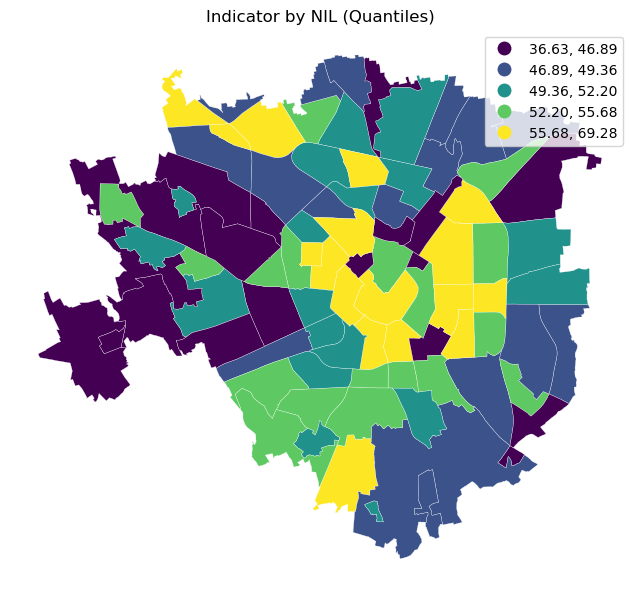

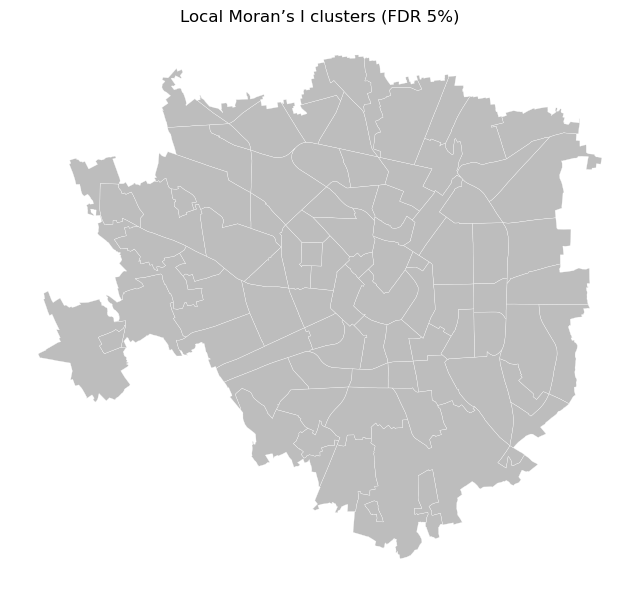

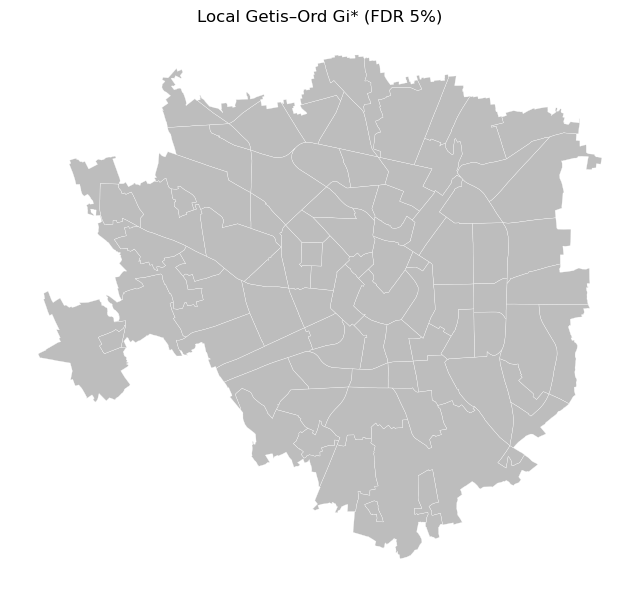

  LISA   n
0   NS  88
  Gi_class   n
0       NS  88
Saved: milan_local_clusters.xlsx

Results written to milan_nil_spatial_stats.gpkg


In [7]:
# ── Imports
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from libpysal.weights import Queen, KNN, lag_spatial
from esda.moran import Moran, Moran_Local
from esda.geary import Geary
from esda.getisord import G, G_Local

# Optional: FDR multiple-testing correction
try:
    from statsmodels.stats.multitest import multipletests
    HAS_SM = True
except Exception:
    HAS_SM = False

# ── 0) (OPTIONAL) Start from your merge result
# gdf_merged_2 = ...  # your object after merging indicator by NIL

# Keep only rows with a valid indicator and geometry
gdf = gdf_merged_2.dropna(subset=['indicator', gdf_merged_2.geometry.name]).copy()
gdf = gdf.reset_index(drop=True)

# Ensure projected CRS for contiguity (or distance) operations
# If your layer is EPSG:4326, pick a projected CRS for Milan (e.g., EPSG:32632 or 25832)
if gdf.crs is None or gdf.crs.to_epsg() in (4326,):
    gdf = gdf.to_crs(epsg=32632)

# Target variable as a numpy array
y = gdf['indicator'].values.astype(float)

# ── 1) Build spatial weights (Queen contiguity, row-standardized)
w = Queen.from_dataframe(gdf)
w.transform = 'R'

# Handle islands (areas with no neighbors): attach 1-NN links so every NIL has at least one neighbor
if w.islands:
    print(f"Found {len(w.islands)} island NIL(s). Adding 1-NN links to ensure connectivity.")
    w_knn = KNN.from_dataframe(gdf, k=1)
    w = w.union(w_knn)     # combine contiguity and kNN
    w.transform = 'R'

# ── 2) GLOBAL INDICATORS
# Moran's I
mi = Moran(y, w, permutations=9999)
# Geary's C
gc = Geary(y, w, permutations=9999)
# Getis–Ord G
g_global = G(y, w, permutations=9999)

print("\n=== GLOBAL SPATIAL AUTOCORRELATION ===")
print(f"Moran's I: {mi.I:.4f}  p-value (perm.): {mi.p_sim:.4f}")
print(f"Geary's C: {gc.C:.4f}  p-value (perm.): {gc.p_sim:.4f}")
print(f"Getis–Ord G: {g_global.G:.4f}  p-value (perm.): {g_global.p_sim:.4f}")

# Store global results for reporting
global_results = {
    "moran_I": mi.I, "moran_p": mi.p_sim,
    "geary_C": gc.C, "geary_p": gc.p_sim,
    "getis_G": g_global.G, "getis_p": g_global.p_sim
}

# ── 3) LOCAL INDICATORS
# Local Moran's I (LISA)
lisa = Moran_Local(y, w, permutations=9999)
# Local Getis–Ord Gi*
gi = G_Local(y, w, permutations=9999)  # Z-scores and p-values

# Benjamini–Hochberg FDR correction for multiple testing (recommended)
if HAS_SM:
    reject_lisa, p_lisa_fdr, _, _ = multipletests(lisa.p_sim, alpha=0.05, method='fdr_bh')
    reject_gi,   p_gi_fdr,   _, _ = multipletests(gi.p_sim,   alpha=0.05, method='fdr_bh')
else:
    reject_lisa = lisa.p_sim < 0.05
    p_lisa_fdr = lisa.p_sim
    reject_gi   = gi.p_sim   < 0.05
    p_gi_fdr    = gi.p_sim

# Quadrant mapping for LISA:
# 1 HH, 2 LH, 3 LL, 4 HL  (Anselin, 1995)
labels = np.array(['NS','HH','LH','LL','HL'])
lisa_sig = np.where(reject_lisa, lisa.q, 0)  # 0 => NS
lisa_labels = labels[lisa_sig]

# Attach results to GeoDataFrame
gdf['moran_I']     = mi.I
gdf['moran_p']     = mi.p_sim
gdf['geary_C']     = gc.C
gdf['geary_p']     = gc.p_sim
gdf['getis_G']     = g_global.G
gdf['getis_p']     = g_global.p_sim

gdf['lisa_Ii']     = lisa.Is
gdf['lisa_p']      = lisa.p_sim
gdf['lisa_p_fdr']  = p_lisa_fdr
gdf['lisa_cluster']= lisa_labels  # 'HH','LL','HL','LH','NS'

gdf['gi_z']        = gi.Zs
gdf['gi_p']        = gi.p_sim
gdf['gi_p_fdr']    = p_gi_fdr
gdf['gi_sig']      = reject_gi

# ── 4) QUICK DIAGNOSTIC PLOTS (optional)
try:
    import mapclassify as mc

    # Choropleth of the indicator
    ax = gdf.plot(column='indicator', cmap='viridis', scheme='Quantiles', k=5, edgecolor='white', linewidth=0.2, legend=True, figsize=(8,8))
    ax.set_title('Indicator by NIL (Quantiles)')
    ax.axis('off')
    plt.show()

    # LISA cluster map
    cluster_colors = {
        'HH':'#e41a1c','LL':'#377eb8','HL':'#4daf4a','LH':'#984ea3','NS':'#bdbdbd'
    }
    gdf['_color'] = gdf['lisa_cluster'].map(cluster_colors)
    ax = gdf.plot(color=gdf['_color'], edgecolor='white', linewidth=0.2, figsize=(8,8))
    ax.set_title('Local Moran’s I clusters (FDR 5%)')
    ax.axis('off')
    plt.show()

    # Gi* hotspots/coldspots (z-scores)
    # Significant only
    gdf['gi_class'] = np.select(
        [ (gdf['gi_sig']) & (gdf['gi_z']>0),
          (gdf['gi_sig']) & (gdf['gi_z']<0) ],
        ['Hotspot (+)','Coldspot (–)'],
        default='NS'
    )
    gi_colors = {'Hotspot (+)':'#d73027', 'Coldspot (–)':'#4575b4', 'NS':'#bdbdbd'}
    ax = gdf.plot(color=gdf['gi_class'].map(gi_colors), edgecolor='white', linewidth=0.2, figsize=(8,8))
    ax.set_title('Local Getis–Ord Gi* (FDR 5%)')
    ax.axis('off')
    plt.show()

except Exception as e:
    print("Plotting skipped:", e)
# LISA counts
lisa_counts = gdf['lisa_cluster'].value_counts().rename_axis('LISA').reset_index(name='n')

# Gi* classes (after you created gi_class)
gi_counts = gdf['gi_class'].value_counts().rename_axis('Gi_class').reset_index(name='n')

print(lisa_counts)
print(gi_counts)

# Top HH by local Moran's statistic
top_HH = (gdf[gdf['lisa_cluster']=='HH']
          .sort_values('lisa_Ii', ascending=False)[['NIL','indicator','lisa_Ii','lisa_p_fdr']].head(10))

# Top hotspots by Gi* z-score
top_hot = (gdf[gdf['gi_class']=='Hotspot (+)']
           .sort_values('gi_z', ascending=False)[['NIL','indicator','gi_z','gi_p_fdr']].head(10))

# Export for the thesis appendix
with pd.ExcelWriter('milan_local_clusters.xlsx') as xl:
    lisa_counts.to_excel(xl, sheet_name='LISA_counts', index=False)
    gi_counts.to_excel(xl, sheet_name='Gi_counts', index=False)
    top_HH.to_excel(xl, sheet_name='Top_HH', index=False)
    top_hot.to_excel(xl, sheet_name='Top_hotspots', index=False)

print("Saved: milan_local_clusters.xlsx")

summary = pd.DataFrame({
    'Moran_I':[gdf['moran_I'].iat[0]], 'Moran_p':[gdf['moran_p'].iat[0]],
    'Geary_C':[gdf['geary_C'].iat[0]], 'Geary_p':[gdf['geary_p'].iat[0]],
    'Getis_G':[gdf['getis_G'].iat[0]], 'Getis_p':[gdf['getis_p'].iat[0]],
    'LISA_HH':[int((gdf['lisa_cluster']=='HH').sum())],
    'LISA_LL':[int((gdf['lisa_cluster']=='LL').sum())],
    'LISA_HL':[int((gdf['lisa_cluster']=='HL').sum())],
    'LISA_LH':[int((gdf['lisa_cluster']=='LH').sum())],
    'Gi_hotspots':[int((gdf['gi_class']=='Hotspot (+)').sum())],
    'Gi_coldspots':[int((gdf['gi_class']=='Coldspot (–)').sum())]
})
summary.to_csv('milan_spatial_summary.csv', index=False)
summary

# ── 5) SAVE RESULTS
out_cols = ['NIL','indicator',
            'moran_I','moran_p','geary_C','geary_p','getis_G','getis_p',
            'lisa_Ii','lisa_p','lisa_p_fdr','lisa_cluster',
            'gi_z','gi_p','gi_p_fdr','gi_sig','geometry']

out_path = "milan_nil_spatial_stats.gpkg"
gdf[out_cols].to_file(out_path, layer='nil_stats', driver='GPKG')
print(f"\nResults written to {out_path}")

In [8]:
# LISA Low–Low clusters (FDR-significant)
ll = (gdf[gdf['lisa_cluster']=='LL']
      .sort_values('lisa_Ii', ascending=False)[['NIL','indicator','lisa_Ii','lisa_p_fdr']])

# Gi* coldspots (FDR-significant)
cold = (gdf[gdf['gi_class']=='Coldspot (–)']
        .sort_values('gi_z')[['NIL','indicator','gi_z','gi_p_fdr']])

print("LISA LL clusters:\n", ll)
print("\nGi* coldspots:\n", cold)

with pd.ExcelWriter('milan_LL_coldspots.xlsx') as xl:
    ll.to_excel(xl, sheet_name='LISA_LL', index=False)
    cold.to_excel(xl, sheet_name='Gi_coldspots', index=False)



LISA LL clusters:
 Empty DataFrame
Columns: [NIL, indicator, lisa_Ii, lisa_p_fdr]
Index: []

Gi* coldspots:
 Empty DataFrame
Columns: [NIL, indicator, gi_z, gi_p_fdr]
Index: []
